In [1]:
# Importing libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

import math

pd.set_option('display.max_rows', 25)  # Display all rows
pd.set_option('display.max_columns', 50)  # Display all columns
pd.set_option('display.width', 100)  # Set the display width to fit the entire DataFrame

#importing file from csv
mca = pd.read_csv(r"C:\Users\ssara\OneDrive\Ambiente de Trabalho\Class 1\4. Labs\9. OCT lab-customer-analysis-round-7\files_for_lab\csv_files\marketing_customer_analysis.csv")
mca

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [2]:
def clean_process(df, max_correlation, ycolumn):
    # Lowercasing column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Dealing with NaNs
    df = df.dropna(axis=1, thresh=len(df) * 0.5)  # Drop columns with more than 50% NaN
    df = df.drop(columns=['unnamed: 0'], errors='ignore')
    df = df.dropna().reset_index(drop=True)
    
    # Splitting Numerical and Categorical data
    numerical = mca._get_numeric_data()
    categorical = mca.drop(numerical.columns,axis=1)
    numerical = numerical.drop(['number_of_open_complaints','number_of_policies'],axis=1)
    categorical = categorical.drop(['customer','effective_to_date'],axis=1)

    # Normalizing data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(numerical)
    normalized_data = pd.DataFrame(normalized_data, columns=numerical.columns)

    # One Hot Encoder
    one_hot_names = []
    for col in categorical.columns:
        col_uniques = sorted(categorical[col].unique())
        for unique in col_uniques:
            one_hot_names.append(unique)
            
    categorical = pd.DataFrame(OneHotEncoder().fit(pd.DataFrame(categorical))
                                 .transform(pd.DataFrame(categorical)).toarray())
    categorical.columns = one_hot_names

    # Standard Scaling
    x_names = numerical.columns
    numerical = pd.DataFrame(StandardScaler().fit(numerical).transform(numerical))
    numerical.columns = list(x_names)

    # Concating DataFrames
    mca_df = pd.concat([numerical,categorical],axis=1)
    return mca_df
    

In [3]:
# Defining the maximum correlation threshold and y column
max_correlation = 0.9
ycolumn = 'total_claim_amount'

# Applying the function
mca_df = clean_process(df=mca, max_correlation=max_correlation, ycolumn=ycolumn)


In [4]:
# A double check

if 'total_claim_amount' in mca.columns:
    print("The column 'total_claim_amount' exists in mca_clean.")
else:
    print("The column 'total_claim_amount' does not exist in mca_clean.")

The column 'total_claim_amount' exists in mca_clean.


In [5]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(mca_df.drop(['total_claim_amount'], axis=1), mca_df['total_claim_amount'], test_size=0.2, random_state = 42)

In [6]:
# Applying linear regression model

Y = Y_train
X = X_train
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_claim_amount   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     541.4
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:41:53   Log-Likelihood:                -4980.4
No. Observations:                7307   AIC:                         1.005e+04
Df Residuals:                    7260   BIC:                         1.038e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0455      0.010     -4.494      0.000      -0.065      -0.026
customer_lifetime_value           0.0033      0.006      0.525      0.600      -0.009       0.015
income                           -0.0308      0.010     -3.077      0.002      -0.050      -0.011
monthly_premium_auto              0.6006      0.029     20.816      0.000       0.544       0.657
months_since_last_claim           0.0087      0.006      1.551      0.121      -0.002       0.020
months_since_policy_inception    -0.0024      0.006     -0.416      0.678      -0.013       0.009
Arizona                          -0.0141      0.012     -1.155      0.248      -0.038       0.010
California                       -0.0090      0.010     -0.896      0.370      -0.029       0.011
Nevada                            0.0052      0.016      0.335      0.737      -0.025       0.036
Oregon                           -0.0246      0.011     -2.322      0.020      -0.045      -0.004
Washington                       -0.0030      0.017     -0.182      0.856      -0.035       0.029
No                                0.0204      0.010      2.079      0.038       0.001       0.040
Yes                              -0.0659      0.011     -6.207      0.000      -0.087      -0.045
Basic                             0.0068      0.018      0.375      0.708      -0.029       0.042
Extended                         -0.0376      0.010     -3.910      0.000      -0.056      -0.019
Premium                          -0.0147      0.028     -0.532      0.595      -0.069       0.039
Bachelor                          0.0104      0.011      0.921      0.357      -0.012       0.033
College                          -0.0148      0.011     -1.308      0.191      -0.037       0.007
Doctor                           -0.0542      0.024     -2.283      0.022      -0.101      -0.008
High School or Below              0.0376      0.012      3.254      0.001       0.015       0.060
Master                           -0.0244      0.018     -1.380      0.168      -0.059       0.010
Disabled                         -0.0527      0.023     -2.280      0.023      -0.098      -0.007
Employed                         -0.0835      0.016     -5.319      0.000      -0.114      -0.053
Medical Leave                    -0.0046      0.023     -0.202      0.840      -0.049       0.040
Retired                          -0.0775      0.028     -2.782      0.005      -0.132      -0.023
Unemployed                        0.1728      0.016     10.657      0.000       0.141       0.205
F                                -0.0458      0.008     -5.960      0.000      -0.061      -0.031
M                                 0.0003      0.008      0.037      0.971      -0.014       0.015
Rural                            -0.7026     

In [7]:
# Adittional Validations

ypred=round(model.predict(X),2)
r2=round(r2_score(Y,ypred),3)
mse=round(mean_squared_error(Y,ypred),3)
rmse=round(math.sqrt(mean_squared_error(Y,ypred)),3)
mae=round(mean_absolute_error(Y,ypred),3)
print("R2:",r2,"MSE:",mse,"RMSE:",rmse,"MAE:",mae) 

R2: 0.774 MSE: 0.229 RMSE: 0.478 MAE: 0.328


# Improving the model


In [8]:
mca_df_numerical = mca_df._get_numeric_data()
mca_df_categorical = mca_df.drop(mca_df_numerical.columns,axis=1)

No correlation higher than 0.9 was found.
Maximum correlation is 0.7938746283027207


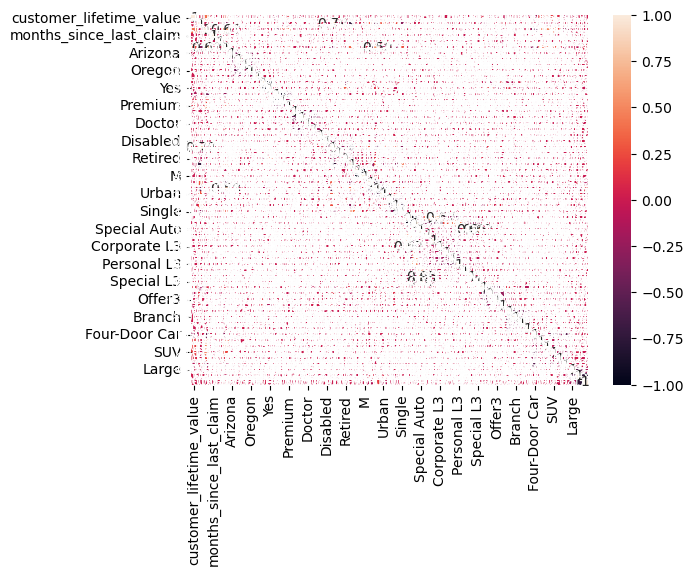

In [39]:
def multic_process(df, max_correlation, ycolumn):
    # Check multicollinearity and drop high correlations
    xcols, ycols, correlation = [], [], []
    for xcol in df.columns:
        for ycol in df.columns:
            if xcol != ycol:
                r = df[xcol].corr(df[ycol])
                correlation.append(r)
                xcols.append(xcol)
                ycols.append(ycol)
                
    dropped_cols = set()
    counter = 0
    for i in range(len(correlation)):
        if correlation[i] > max_correlation:
            xcol, ycol = xcols[i], ycols[i]
            if xcol not in dropped_cols and ycol not in dropped_cols:
                if df[xcol].std() > df[ycol].std():
                    df = df.drop(columns=[ycol], axis=1)
                    dropped_cols.add(ycol)
                else:
                    df = df.drop(columns=[xcol], axis=1)
                    dropped_cols.add(xcol)
            counter += 1

    if counter == 0:
        print('No correlation higher than', max_correlation, 'was found.')
    else:
        print(counter, 'correlations higher than 0.9 were found.', len(dropped_cols), 'columns were dropped.')

    print('Maximum correlation is', max(correlation))

    sns.heatmap(df.corr(), annot=True) 
    plt.show()
    
    return df

max_correlation = 0.9
ycolumn = 'total_claim_amount'
mca_df_numerical = multic_process(df=mca_df, max_correlation=max_correlation, ycolumn=ycolumn)

# Concating DataFrames
mca_df_categorical = mca_df.drop(mca_df_numerical.columns, axis=1)
mca_df_2 = pd.concat([mca_df_numerical, mca_df_categorical], axis=1)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(mca_df_2.drop([ycolumn], axis=1), mca_df_2[ycolumn], test_size=0.2, random_state=42)

In [40]:
# Applying linear regression model
columns_to_drop = ['customer_lifetime_value','months_since_last_claim','months_since_policy_inception',
                   'Arizona','California','Nevada','Washington','Premium','Bachelor',
                   'College','High School or Below','Master','Medical Leave','M','Corporate L1',
                   'Corporate L2','Corporate L3','Basic','Two-Door Car','Large','Small']
Y = Y_train
X = X_train.drop(columns=columns_to_drop)
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

ypred=round(model.predict(X),2)
r2=round(r2_score(Y,ypred),3)
mse=round(mean_squared_error(Y,ypred),3)
rmse=round(math.sqrt(mean_squared_error(Y,ypred)),3)
mae=round(mean_absolute_error(Y,ypred),3)
print("R2:",r2,"MSE:",mse,"RMSE:",rmse,"MAE:",mae) 

R2: 0.774 MSE: 0.23 RMSE: 0.479 MAE: 0.329


In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_claim_amount   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     753.3
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:59:15   Log-Likelihood:                -4990.5
No. Observations:                7307   AIC:                         1.005e+04
Df Residuals:                    7273   BIC:                         1.028e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0558      0.011     -4.881      0.000      -0.078      -0.033
income                  -0.0302      0.010     -3.016      0.003      -0.050      -0.011
monthly_premium_auto     0.5901      0.013     45.939      0.000       0.565       0.615
Oregon                  -0.0179      0.012     -1.439      0.150      -0.042       0.006
No                       0.0168      0.009      1.767      0.077      -0.002       0.035
Yes                     -0.0726      0.011     -6.314      0.000      -0.095      -0.050
Extended                -0.0369      0.013     -2.740      0.006      -0.063      -0.011
Doctor                  -0.0608      0.029     -2.084      0.037      -0.118      -0.004
Disabled                -0.0478      0.037     -1.298      0.194      -0.120       0.024
Employed                -0.0797      0.029     -2.732      0.006      -0.137      -0.023
Retired                 -0.0748      0.042     -1.788      0.074      -0.157       0.007
Unemployed               0.1790      0.029      6.106      0.000       0.122       0.237
F                       -0.0460      0.011     -4.057      0.000      -0.068      -0.024
Rural                   -0.7081      0.011    -62.501      0.000      -0.730      -0.686
Suburban                 0.6023      0.009     67.255      0.000       0.585       0.620
Urban                    0.0499      0.012      4.323      0.000       0.027       0.073
Divorced                -0.0839      0.012     -7.148      0.000      -0.107      -0.061
Married                 -0.1070      0.009    -12.504      0.000      -0.124      -0.090
Single                   0.1350      0.011     12.607      0.000       0.114       0.156
Corporate Auto          -0.0493      0.012     -4.074      0.000      -0.073      -0.026
Personal Auto           -0.0376      0.008     -4.483      0.000      -0.054      -0.021
Special Auto             0.0310      0.017      1.799      0.072      -0.003       0.065
Personal L1             -0.0004      0.012     -0.033      0.973      -0.024       0.023
Personal L2             -0.0194      0.010     -1.934      0.053      -0.039       0.000
Personal L3             -0.0177      0.009     -2.006      0.045      -0.035      -0.000
Special L1               0.1277      0.051      2.508      0.012       0.028       0.227
Special L2              -0.0419      0.037     -1.130      0.259      -0.115       0.031
Special L3              -0.0548      0.038     -1.426      0.154      -0.130       0.021
Offer1                  -0.0443      0.009     -4.683      0.000      -0.063      -0.026
Offer2                   0.0242      0.010      2.406      0.016       0.004       0.044
Offer3                  -0.0128      0.013     -1.020      0.308      -0.037       0.012
Offer4                  -0.0230      0.014     -1.611    

In [12]:
# I analyzed the above P>|t| and tried to drop the columns with a relation over 0,05. However, after several atempts the model
# does not change significatively. Also, tried to move the random state from 42 to 100 or to 21 and was always even worse. 


R2: 0.774 MSE: 0.229 RMSE: 0.478 MAE: 0.328
